# Qube セットアップ

In [455]:
# 調子悪い時に実行
from qubecalib import Qube, LongSend, Recv
import qubecalib.qube
QUBE = Qube(config_file_name='qube_riken_1-10.yml')
QUBE.config

{'bitfile': '0d5ea1.bit',
 'ipfpga': '10.1.0.28',
 'iplsi': '10.5.0.28',
 'macfpga': '00-0A-35-0D-5E-A1',
 'maclsi': '00-1B-1A-EE-01-27',
 'type': 'A'}

## FPGA コンフィグ （電源投入時に一度だけ実行）

In [456]:
QUBE.config_fpga()

'\n****** Vivado v2020.1 (64-bit)\n  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020\n  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020\n    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.\n\nsource ./adi_api_mod/utils/config.tcl\n# open_hw_manager\n# connect_hw_server -allow_non_jtag\nINFO: [Labtools 27-2285] Connecting to hw_server url TCP:localhost:3121\nINFO: [Labtools 27-2222] Launching hw_server...\nINFO: [Labtools 27-2221] Launch Output:\n\n****** Xilinx hw_server v2020.1\n  **** Build date : May 27 2020 at 20:33:44\n    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.\n\n\nINFO: [Labtools 27-3415] Connecting to cs_server url TCP:localhost:3042\nINFO: [Labtools 27-3417] Launching cs_server...\nINFO: [Labtools 27-2221] Launch Output:\n\n\n****** Xilinx cs_server v2020.1.0\n  **** Build date : May 14 2020-10:10:29\n    ** Copyright 2017-2020 Xilinx, Inc. All Rights Reserved.\n\n\n\n# open_hw_target\nINFO: [Labtoolstcl 44-466] Opening hw_target localhos

## LSI 類の初期化（電源投入次に一度だけ実行）

In [457]:
QUBE.do_init(message_out=False)
print(QUBE.ad9082[0].get_jesd_status())
print(QUBE.ad9082[1].get_jesd_status())

[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


## AD/DA の初期化（調子の悪い時に実行）

In [458]:
[o.do_init(message_out=False) for o in QUBE.ad9082]
print(QUBE.ad9082[0].get_jesd_status())
print(QUBE.ad9082[1].get_jesd_status())

[['0x55E', '0x90'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


## AD/DA の動作確認（0x55E が 0xE0 以外なら異常）

In [459]:
print(QUBE.ad9082[0].get_jesd_status())
print(QUBE.ad9082[1].get_jesd_status())

[['0x55E', '0x90'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


## アップコンバータのモード設定（電源投入時に実行）

In [460]:
QUBE.port[0].upconv.lsi.mode = qubecalib.qube.ConvMode.USB
QUBE.port[13].upconv.lsi.mode = qubecalib.qube.ConvMode.USB

# アナログ LSI のステータス一覧（いつ実行しても良い）

In [461]:
['{}: {}'.format(k, v.status) for k, v in QUBE.port.items()]

['0: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 '1: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz ',
 '5: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '6: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '7: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '8: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '12: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz ',
 '13: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive']

# 周波数設定の例

ボート０を 10109.5 MHz に設定する．LO は 8000MHz とする．
ポート０の出力を 0x800 (=2048) に設定する．（0~4095まで設定でき，4095が最大値だが，3072ぐらいまでに留めて．）
受信機の NCO を nco_mhz に設定する．

In [271]:
# 読出し
nco_mhz, awg_mhz = QUBE.port[13].set_freq(10109.5, 8000) #(周波数, LO周波数)
#QUBE.port[0].upconv.vatt = 0x380
QUBE.port[13].upconv.vatt = 0x800 #ゲイン(0~4096)
QUBE.port[12].adc.nco.freq = nco_mhz #レシーバのNCO周波数

# コントロール
nco_mhz, awg_mhz = QUBE.port[6].set_freq(8320, 9000)
print(nco_mhz, awg_mhz)
QUBE.port[6].dac.nco.freq = nco_mhz
QUBE.port[6].upconv.vatt = 0x7b0
#print(10109.5 + 906.25 - 11000)

# print(QUBE.port[0].status)
print(QUBE.port[5].status)
print(QUBE.port[6].status)

671.875 8.125
RF = 8328.125 MHz LO =  9000    MHz IF = 671.875 MHz LSB/USB: LSB MODE AWG: Inactive
RF = 8328.125 MHz LO =  9000    MHz IF = 671.875 MHz LSB/USB: LSB MODE AWG: Inactive


In [264]:
9000 - 8984.375

15.625

# CW出力（主に試験信号の出力）

In [257]:
# 出力開始 awg_mhz-2.5MHzだけずれる
LongSend.start(QUBE.port[13])

In [258]:
# 出力停止
LongSend.stop(QUBE.port[13])

# 制御パルス送信コード

`rabi_meas()` を実行した時に `NameError: name 'rabi_meas' is not defined` と怒られたら実行すること

In [470]:
# 1度だけ実行

from collections import namedtuple
from e7awgsw import AWG, AwgCtrl, CaptureCtrl, CaptureModule, CaptureParam, DspUnit, SinWave, IqWave
from e7awgsw import WaveSequence
import numpy as np


ADDITIONAL_CAPTURE_DELAY = 0 # cpature words = cycyles @ 125MHz 

wave_params = namedtuple(
    'WaveParams',
    ('num_wait_words',
     'ctrl_freq',
     'ctrl_wave_len',
     'readout_freq',
     'readout_wave_len',
     'readout_blank_len',
     'num_chunk_repeats',
     'ctrl_amp',
     'readout_amp',
    ))


awg_list = namedtuple(
    'AwgList',
    ('ctrl_awg_0',
     'ctrl_awg_1',
     'readout_awg_0',
     'readout_awg_1'))

# # port5
# AWG_LIST = awg_list(
#     ctrl_awg_0 = AWG.U11,
#     ctrl_awg_1 = AWG.U0,
#     readout_awg_0 = AWG.U2,
#     readout_awg_1 = AWG.U15
# )

# port6
AWG_LIST = awg_list(
    ctrl_awg_0 = AWG.U8,
    ctrl_awg_1 = AWG.U0,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)



def set_trigger_awg(cap_ctrl, awg, capture_modules):
    for cap_mod_id in capture_modules:
        cap_ctrl.select_trigger_awg(cap_mod_id, awg)
        cap_ctrl.enable_start_trigger(*CaptureModule.get_units(cap_mod_id))

        
def set_wave_sequence(awg_ctrl, params):
    
    def gen_cos_wave(freq, num_cycles, amp, sampling_rate):
        freq = freq * 1e6
        o = 2 * math.pi * num_cycles
        i_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = - o + math.pi / 2).gen_samples(sampling_rate)
        q_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = - o).gen_samples(sampling_rate)
        return (i_samples, q_samples)
    
    def gen_ctrl_wave_samples():
        
        num_cycles = params.ctrl_freq * params.ctrl_wave_len * 1e-3
        i, q = gen_cos_wave(params.ctrl_freq, num_cycles, params.ctrl_amp, AwgCtrl.SAMPLING_RATE)
        
        m = WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK
        padding = m - (len(i) % m)
        long_padding = (NUM_OFFSET_BLOCKS * m) - (padding + len(i))
        i = [0] * (long_padding + padding) + i
        q = [0] * (long_padding + padding) + q
        return (i, q)
    
    def gen_ctrl_wave_seq(num_all_samples, i_samples, q_samples):
        iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
        num_blank_samples = num_all_samples - len(iq_samples)
        num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

        wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
        wave_seq.add_chunk(
            iq_samples = iq_samples,
            num_blank_words = num_blank_words, 
            num_repeats = params.num_chunk_repeats
        )
        return wave_seq
    
    def gen_readout_wave_samples(num_pre_blank_samples):
        num_cycles = params.readout_freq * params.readout_wave_len * 1e-3
        i_samples, q_samples = gen_cos_wave(params.readout_freq, num_cycles, params.readout_amp, AwgCtrl.SAMPLING_RATE)
        i_samples = [0] * num_pre_blank_samples + i_samples
        q_samples = [0] * num_pre_blank_samples + q_samples
        return (i_samples, q_samples)

    def gen_readout_wave_seq(i_samples, q_samples):
        iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
        # I/Q サンプルに付加された 0 データの分 readout 波形のブランクを短くする
        num_added_samples = len(iq_samples) - len(i_samples)
        num_blank_samples = max(
            int(AwgCtrl.SAMPLING_RATE * params.readout_blank_len / 1e3) - num_added_samples, 0) # 負にならないよう max(x,0)
        num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

        wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
        wave_seq.add_chunk(
            iq_samples = iq_samples,
            num_blank_words = num_blank_words, 
            num_repeats = params.num_chunk_repeats
        )
        return wave_seq
    
    ctrl_i_samples, ctrl_q_samples = gen_ctrl_wave_samples() # サンプル作成
    ro_i_samples, ro_q_samples = gen_readout_wave_samples(len(ctrl_i_samples)) # サンプル作成
    
#     x = ctrl_i_samples
#     time = np.linspace(0, 1e+6 * len(x) / CaptureCtrl.SAMPLING_RATE, len(x))
#     plt.plot(time, array(x))
    
#     x = ro_i_samples
#     time = np.linspace(0, 1e+6 * len(x) / CaptureCtrl.SAMPLING_RATE, len(x))
#     plt.plot(time, array(x))
    
    ro_wave_seq = gen_readout_wave_seq(ro_i_samples, ro_q_samples) # 波形シーケンス作成
    ctrl_wave_seq = gen_ctrl_wave_seq(ro_wave_seq.chunk(0).num_samples, ctrl_i_samples, ctrl_q_samples)

    # control 波形と readout 波形の長さが一致することを確認
    assert ctrl_wave_seq.num_all_words == ro_wave_seq.num_all_words

    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_0, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_1, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_0, ro_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_1, ro_wave_seq)
    return {
        AWG_LIST.ctrl_awg_0 : ctrl_wave_seq,
        AWG_LIST.ctrl_awg_1 : ctrl_wave_seq,
        AWG_LIST.readout_awg_0 : ro_wave_seq,
        AWG_LIST.readout_awg_1 : ro_wave_seq
    }


def set_capture_params(cap_ctrl, ctrl_wave_seq, ro_wave_seq, capture_units):
    
    def gen_capture_param(ctrl_wave_seq, ro_wave_seq):
        capture_param = CaptureParam()
        capture_param.num_integ_sections = ro_wave_seq.chunk(0).num_repeats # 積算区間数

        # readout 波形の長さから, 追加で 1us キャプチャするためのキャプチャワード数を計算
        additional_capture_words = int(1e-6 * CaptureCtrl.SAMPLING_RATE) // CaptureParam.NUM_SAMPLES_IN_ADC_WORD
        additional_capture_words = min(additional_capture_words, ro_wave_seq.chunk(0).num_blank_words - 1)
        
        sum_section_len = ro_wave_seq.chunk(0).num_words - ro_wave_seq.chunk(0).num_blank_words + additional_capture_words
        num_blank_words = ro_wave_seq.chunk(0).num_words - sum_section_len

        if DEBUG:
            capture_param.add_sum_section(sum_section_len, num_blank_words)
            capture_param.sum_start_word_no = 0
            capture_param.num_words_to_sum = CaptureParam.MAX_SUM_SECTION_LEN
            # capture_param.sel_dsp_units_to_enable(DspUnit.INTEGRATION)
            capture_param.capture_delay = 0#ctrl_wave_seq.num_wait_words + ctrl_wave_seq.chunk(0).num_wave_words
            # capture_param.capture_delay += ADDITIONAL_CAPTURE_DELAY
        else:
            capture_param.add_sum_section(sum_section_len, num_blank_words)
            capture_param.sum_start_word_no = 0
            capture_param.num_words_to_sum = CaptureParam.MAX_SUM_SECTION_LEN
            capture_param.sel_dsp_units_to_enable(DspUnit.INTEGRATION)
            capture_param.capture_delay = 0# ctrl_wave_seq.num_wait_words + ctrl_wave_seq.chunk(0).num_wave_words
            # capture_param.capture_delay += ADDITIONAL_CAPTURE_DELAY
        # readout 波形のサンプル数とキャプチャするサンプル数が一致することを確認
        assert ro_wave_seq.num_all_samples == capture_param.num_samples_to_process
        return capture_param

    capture_param = gen_capture_param(ctrl_wave_seq, ro_wave_seq)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)

def get_capture_data(cap_ctrl, capture_units):
    capture_unit_to_capture_data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_id)
        capture_unit_to_capture_data[capture_unit_id] = cap_ctrl.get_capture_data(capture_unit_id, num_captured_samples)
    return capture_unit_to_capture_data


def check_err(awg_ctrl, cap_ctrl, awgs, capture_units):
    awg_to_err = awg_ctrl.check_err(*awgs)
    for awg_id, err_list in awg_to_err.items():
        print(awg_id)
        for err in err_list:
            print('    {}'.format(err))
    
    cap_unit_to_err = cap_ctrl.check_err(*capture_units)
    for cap_unit_id, err_list in cap_unit_to_err.items():
        print('{} err'.format(cap_unit_id))
        for err in err_list:
            print('    {}'.format(err))

def rabi_meas(wparams):

    capture_modules = QUBE.port[1].adc.caps + QUBE.port[12].adc.caps
    capture_units = CaptureModule.get_units(*capture_modules)

    cap_ctrl = CaptureCtrl(QUBE.config['ipfpga'])
    awg_ctrl = AwgCtrl(QUBE.config['ipfpga'])

    # 初期化
    awg_ctrl.initialize(*AWG_LIST)
    cap_ctrl.initialize(*capture_units)

    # トリガ AWG の設定
    set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)

    # 波形シーケンスの設定
    awg_to_wave_sequence = set_wave_sequence(awg_ctrl, wparams)

    # キャプチャパラメータの設定
    set_capture_params(
        cap_ctrl,
        awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
        awg_to_wave_sequence[AWG_LIST.readout_awg_0],
        capture_units)

    # 波形送信スタート
    awg_ctrl.start_awgs(*AWG_LIST)

    # 波形送信完了待ち
    awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)

    # キャプチャ完了待ち
    cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)

    # エラーチェック
    check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)

    # キャプチャデータ取得
    return get_capture_data(cap_ctrl, capture_units)



# ラビ振動測定コード（ここが主役）

適当に複製，変更して使ってください．

In [471]:
!pip3 install sklearn
!pip3 install scipy

In [473]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

6.325000000000728 9428.2
10.325000000000728 8317.8
0: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive
1: RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz 
5: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
6: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
7: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
8: RF = 8328.125 MHz LO =  9000    MHz IF = 671.875 MHz LSB/USB: LSB MODE AWG: Inactive
12: RF = 9421.875 MHz LO =  8000    MHz IF = 1421.875 MHz 
13: RF = 9421.875 MHz LO =  8000    MHz IF = 1421.875 MHz LSB/USB: USB MODE AWG: Inactive
1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 103 106 109 112 115 118 121 124 127 130 133 136 139 142 145 148 151 154 157 160 163 166 169 172 175 178 181 184 187 190 193 196 199 

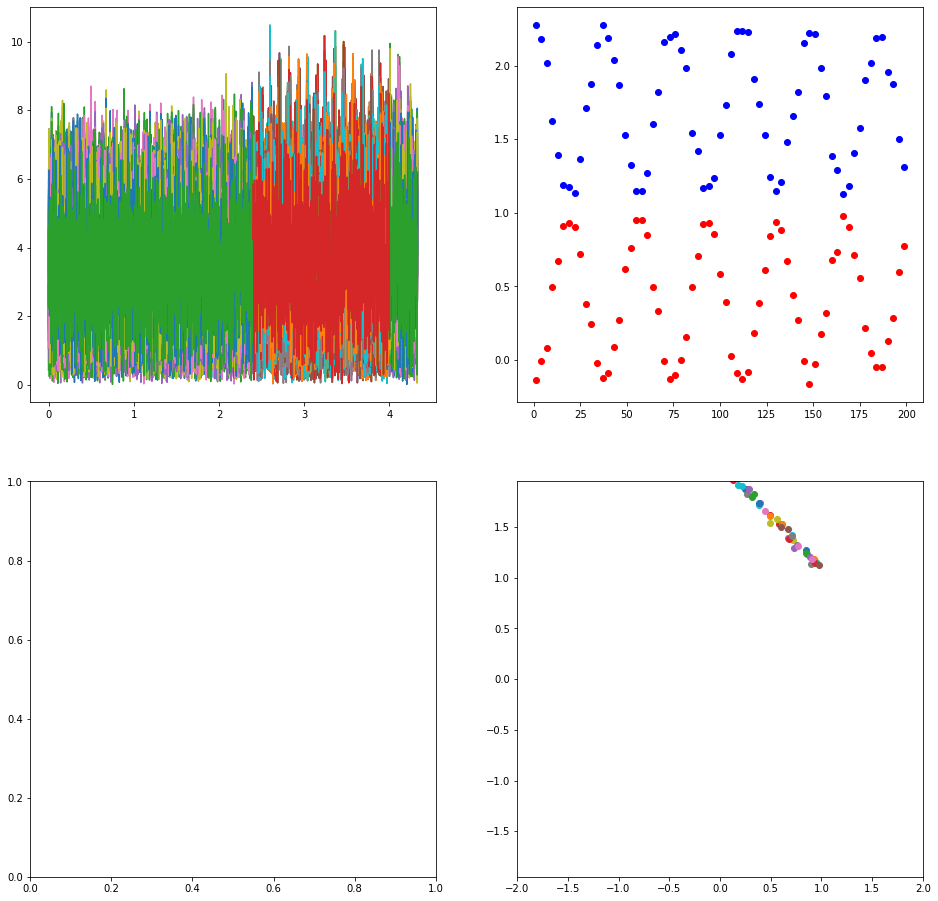

In [476]:
from collections import namedtuple
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, real, imag, abs, log
from e7awgsw import CaptureUnit
from numpy.fft import fft

DEBUG = False

convert = lambda x: x[:,0] + 1j * x[:,1]


# READOUT_TARGET_FREQUENCY = 9217.5 # Hz
# CTRL_TARGET_FREQUENCY = 7555.9 # MHz
READOUT_TARGET_FREQUENCY = 9428.2 # Hz
CTRL_TARGET_FREQUENCY = 8317.8 # MHz

NUM_OFFSET_BLOCKS = 10 # 128 [ns/block] x 100 [blocks] = 12.8 [us]
readout_lo_mhz = 8000 #変えない方がいい, 500MHz単位
ctrl_lo_mhz = 9000 #変えない方がいい, 500MHz単位


wave_params = namedtuple(
    'WaveParams',
    ('num_wait_words',
     'ctrl_freq',
     'ctrl_wave_len',
     'readout_freq',
     'readout_wave_len',
     'readout_blank_len',
     'num_chunk_repeats',
     'ctrl_amp',
     'readout_amp',
    ))

# DAC の NCO と Readout の LMX の設定
nco_mhz, awg_mhz = QUBE.port[13].set_freq(READOUT_TARGET_FREQUENCY, readout_lo_mhz)
readout_vatt = 0x800#0x300 #0x500
QUBE.port[13].upconv.vatt = readout_vatt
readout_awg_mhz = awg_mhz
readout_rf_mhz = nco_mhz + readout_lo_mhz + awg_mhz
print(awg_mhz, readout_rf_mhz)

# Readin の LMX は Readout と同じ値
QUBE.port[12].adc.nco.freq = nco_mhz # ADC の NCO の設定

nco_mhz, awg_mhz = QUBE.port[8].set_freq(CTRL_TARGET_FREQUENCY, ctrl_lo_mhz)
ctrl_awg_mhz = awg_mhz
ctrl_vatt = 0x800
QUBE.port[8].upconv.vatt = ctrl_vatt
# QUBE.port[5].upconv.vatt = 0x000
ctrl_rf_mhz = ctrl_lo_mhz - nco_mhz - awg_mhz
print(awg_mhz, ctrl_rf_mhz)

[print('{}: {}'.format(k, v.status)) for k, v in QUBE.port.items()]

rslt = {
    'ctrl_vatt': ctrl_vatt,
    'readout_vatt': readout_vatt,
    'readout_rf_mhz': readout_rf_mhz,
    'readout_lo_mhz': readout_lo_mhz,
    'ctrl_rf_mhz': ctrl_rf_mhz,
    'ctrl_lo_mhz': ctrl_lo_mhz,
    'data': [],
}

#for readout_awg_mhz in range(1,16):

pulse_length_list = np.arange(1, 200, 3) # 0はダメ, 最小単位:2ns
z0 = pulse_length_list + 0.j
i = 0

fig, ax = plt.subplots(2, 2, figsize=(16,16))
for c in pulse_length_list: 

    prm = wave_params(
        num_wait_words = 0,
        ctrl_freq = ctrl_awg_mhz, # MHz
        ctrl_wave_len = c, # ns
        readout_freq = readout_awg_mhz, # MHz,
        readout_wave_len = 2000, # ns,
        readout_blank_len = 0.03, # ms
        num_chunk_repeats = 30000, # 積算回数
        # ctrl_amp = 16383, # 17500 -> 81.3 mV
        ctrl_amp = 1861*2, #10000/4, #32767, # 17500 -> 81.3 mV, 32767がmax
        # ctrl_amp = 0,
        readout_amp = 3000, #32767,
        #readout_amp = 10000, #8191,
        # readout_amp = 9830, # -10dB
    )
    
    print(c, end=' ', flush=True)
    d = rabi_meas(prm)
    
    rslt['data'].append({
        'wparams': prm._asdict(),
        'data': d,
    })
    
    s = slice(1200,2000)
    
    x = convert(array(d[CaptureUnit.U0]))
    time = np.linspace(0, 1e+6 * x.shape[0] / CaptureCtrl.SAMPLING_RATE, x.shape[0])# - c * 1e-3
    #ax[0].plot(time, real(x))
    #ax[0].plot(time[s], real(x)[s])


    y = x * np.exp(-1j*2*np.pi*prm.readout_freq*time) / prm.num_chunk_repeats
    z = y[s].mean()
    
    z0[i] = z
    i += 1
    
    # ax[0,0].plot(time, real(y))
    # ax[0,0].plot(time, imag(y))
    # ax[0,0].plot(time[s], real(y)[s])
    # ax[0,0].plot(time[s], imag(y)[s])
    ax[0,0].plot(time, np.abs(y))
    ax[0,0].plot(time[s], np.abs(y)[s])
    
    ax[0,1].plot(c,real(z), 'ro')
    ax[0,1].plot(c,imag(z), 'bo')
    
    ax[1,1].plot(real(z),imag(z),'o')
    ax[1,1].axis('equal')
    ax[1,1].set_xlim(-2,2)
    ax[1,1].set_ylim(-2,2)
    #ax[1].plot(c, np.angle(z),'o')

    
# import pickle, datetime
# n = datetime.datetime.now()
# with open('HandaiExpRabi20220421{}{}.pickle'.format(n.hour, n.minute), 'wb') as f:
#     pickle.dump(rslt, f)


In [477]:
## 直線フィッティング
    
# 分布(x, y)を直線フィッティングして, フィッティング後のyの値, 傾き, y切片を取得
def linear_fitting(x, y):
    model = LinearRegression() # 線形回帰モデル
    x_T = x[:,np.newaxis] # 縦ベクトルに変換する必要あり
    model.fit(x_T, y) # モデルを訓練データに適合, 引数は縦ベクトルでないといけない
    y_fit = model.predict(x_T) # 引数は縦ベクトルでないといけない
    grad = model.coef_ # 傾き
    intercept = model.intercept_ # y切片
    return y_fit, grad, intercept

# 分布(x, y)を回転して, y方向の分布にマップする
# grad, intercept: (x, y)を直線フィッティングした時の傾き, y切片
def rotation_conversion(x, y, grad, intercept):
    i = 1
    if intercept > 0:
        i = 0
    x_after = x * np.cos(np.arctan2(1, grad) + i*np.pi - 0.) - y * np.sin(np.arctan2(1, grad) + i*np.pi -0.)
    y_after = x * np.sin(np.arctan2(1, grad) + i*np.pi -0. ) + y * np.cos(np.arctan2(1, grad) + i*np.pi -0.)
    return x_after, y_after
    

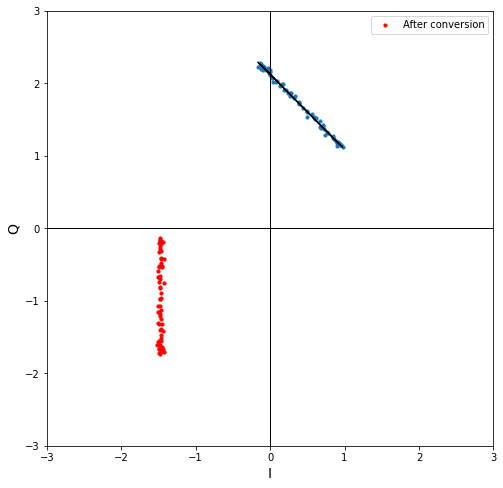

In [478]:

plt.rcParams["figure.figsize"] = (8, 8) # プロット前にグラフサイズだけ先に決めておく


plt.scatter(np.real(z0), np.imag(z0), s=10)

imag_fit = linear_fitting(np.real(z0), np.imag(z0))[0] # 直線フィッティング
plt.plot(np.real(z0), imag_fit, color = 'black', linewidth = 1) # フィッティング直線の描画

grad, intercept = linear_fitting(np.real(z0), np.imag(z0))[1:] # 直線フィッティングの各パラメータ取得
real_after, imag_after = rotation_conversion(np.real(z0), np.imag(z0), grad, intercept) # 平均値の分布を回転して, y方向の分布にマップする
plt.scatter(real_after, imag_after, label = 'After conversion', color = "red", s=10) # 回転変換後の分布を描画する


# 描画設定
plt.plot(np.linspace(-20, 20, 2), np.zeros(2), linewidth = 1, color='black')
plt.plot(np.zeros(2), np.linspace(-20, 20, 2), linewidth = 1, color='black')
plt.xlabel('I', fontsize=14)     # x軸の名称とフォントサイズ
plt.ylabel('Q', fontsize=14)     # y軸の名称とフォントサイズ
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))    # ラベルを右上に記載
plt.show()

parameter -> [ 8.07707501e-01  1.59515656e+03  2.69221942e-02 -1.74217069e+00]


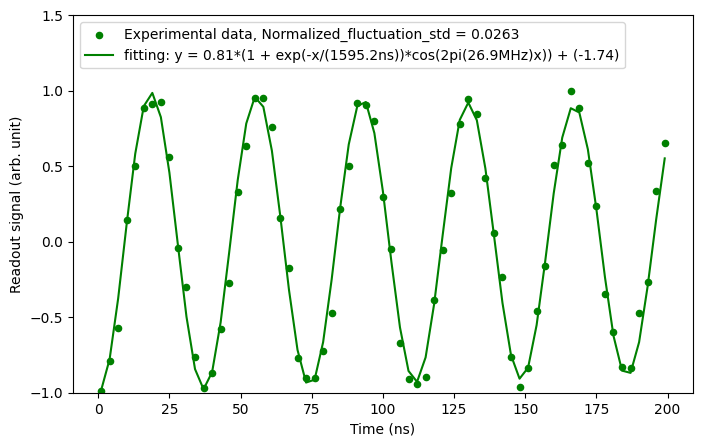

In [479]:
##### 時間測定結果をグラフに描画 #####
fig = plt.figure(figsize=(8, 5), dpi=100)
plt.rcParams["figure.figsize"] = (8, 5)

# 関数指定フィッティング
def func(pulse_duration, A, B, C, D): #フィッティング関数の定義
    return A * (1 - np.exp(- pulse_duration/B) * np.cos(2*np.pi * C * pulse_duration)) + D
prameter_initial = np.array([5, 100, 0.01, -0.003]) #初期値
popt, pcov = curve_fit(func, pulse_length_list, imag_after, p0 = prameter_initial, maxfev = 100000) #最適化
print ("parameter ->", popt)
func_fit = func(np.array(pulse_length_list), *popt) #フィッティング後の値
# plt.plot(x_list, func_fit, color = 'red', linewidth = 2)

imag_after_norm = (imag_after - popt[3]) / popt[0] - 1
func_fit_norm = (func_fit - popt[3]) / popt[0] - 1

normalized_fluctuation_std = np.std(real_after / popt[0]) # 規格化した実測データとフィッティング関数との差分の標準偏差

plt.scatter(pulse_length_list, imag_after_norm, color="green", s=20,\
    label=f"Experimental data, Normalized_fluctuation_std = {round(normalized_fluctuation_std,4)}")
plt.plot(pulse_length_list, func_fit_norm, color = 'green', linewidth = 1.5,  \
    label=f"fitting: y = {round(popt[0],2)}*(1 + exp(-x/({round(popt[1],1)}ns))*cos(2pi({round(popt[2]*1e3,1)}MHz)x)) + ({round(popt[3],2)})")


# 描画設定
plt.xlabel('Time (ns)', fontsize=10)     # x軸の名称とフォントサイズ
plt.ylabel('Readout signal (arb. unit)', fontsize=10)     # y軸の名称とフォントサイズ
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left')#, bbox_to_anchor=(1, 1))    # ラベルを右上に記載
# plt.title(str(folder))
plt.ylim(-1,1.5)
# plt.xlim(0,1300)
plt.show()

## データの保存用コード

In [216]:
import pickle, datetime
n = datetime.datetime.now()
with open('HandaiExpRabi20220425{}{}.pickle'.format(n.hour, n.minute), 'wb') as f:
    pickle.dump(rslt, f)

## データの読み出しサンプル

In [111]:
with open('HandaiExpRabi202204211455.pickle', 'rb') as f:
    r = pickle.load(f)

In [489]:
from collections import namedtuple
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, real, imag, abs, log
from e7awgsw import CaptureUnit
from numpy.fft import fft

DEBUG = False

convert = lambda x: x[:,0] + 1j * x[:,1]


# READOUT_TARGET_FREQUENCY = 9217.5 # Hz
# CTRL_TARGET_FREQUENCY = 7555.9 # MHz
READOUT_TARGET_FREQUENCY = 9428.2 # Hz
CTRL_TARGET_FREQUENCY = 8317.8 # MHz

NUM_OFFSET_BLOCKS = 10 # 128 [ns/block] x 100 [blocks] = 12.8 [us]
readout_lo_mhz = 8000 #変えない方がいい, 500MHz単位
ctrl_lo_mhz = 9000 #変えない方がいい, 500MHz単位


wave_params = namedtuple(
    'WaveParams',
    ('num_wait_words',
     'ctrl_freq',
     'ctrl_wave_len',
     'readout_freq',
     'readout_wave_len',
     'readout_blank_len',
     'num_chunk_repeats',
     'ctrl_amp',
     'readout_amp',
    ))

# DAC の NCO と Readout の LMX の設定
nco_mhz, awg_mhz = QUBE.port[13].set_freq(READOUT_TARGET_FREQUENCY, readout_lo_mhz)
readout_vatt = 0x800#0x300 #0x500
QUBE.port[13].upconv.vatt = readout_vatt
readout_awg_mhz = awg_mhz
readout_rf_mhz = nco_mhz + readout_lo_mhz + awg_mhz
print(awg_mhz, readout_rf_mhz)

# Readin の LMX は Readout と同じ値
QUBE.port[12].adc.nco.freq = nco_mhz # ADC の NCO の設定


FREQUENCY_LIST = np.arange(-40, 40, 2.5)
chevron = {}
for f in FREQUENCY_LIST:
    
    nco_mhz, awg_mhz = QUBE.port[8].set_freq(CTRL_TARGET_FREQUENCY + f, ctrl_lo_mhz)
    ctrl_awg_mhz = awg_mhz
    ctrl_vatt = 0x800
    QUBE.port[8].upconv.vatt = ctrl_vatt
    # QUBE.port[5].upconv.vatt = 0x000
    ctrl_rf_mhz = ctrl_lo_mhz - nco_mhz - awg_mhz
    print(awg_mhz, ctrl_rf_mhz)

    # [print('{}: {}'.format(k, v.status)) for k, v in QUBE.port.items()]

    rslt = {
        'ctrl_vatt': ctrl_vatt,
        'readout_vatt': readout_vatt,
        'readout_rf_mhz': readout_rf_mhz,
        'readout_lo_mhz': readout_lo_mhz,
        'ctrl_rf_mhz': ctrl_rf_mhz,
        'ctrl_lo_mhz': ctrl_lo_mhz,
        'data': [],
    }

    #for readout_awg_mhz in range(1,16):

    pulse_length_list = np.arange(1, 200, 4) # 0はダメ, 最小単位:2ns
    z0 = pulse_length_list + 0.j
    i = 0

    # fig, ax = plt.subplots(2, 2, figsize=(16,16))
    for c in pulse_length_list: 

        prm = wave_params(
            num_wait_words = 0,
            ctrl_freq = ctrl_awg_mhz, # MHz
            ctrl_wave_len = c, # ns
            readout_freq = readout_awg_mhz, # MHz,
            readout_wave_len = 2000, # ns,
            readout_blank_len = 0.03, # ms
            num_chunk_repeats = 30000, # 積算回数
            # ctrl_amp = 16383, # 17500 -> 81.3 mV
            ctrl_amp = 1861, #10000/4, #32767, # 17500 -> 81.3 mV, 32767がmax
            # ctrl_amp = 0,
            readout_amp = 3000, #32767,
            #readout_amp = 10000, #8191,
            # readout_amp = 9830, # -10dB
        )

        print(c, end=' ', flush=True)
        d = rabi_meas(prm)

        rslt['data'].append({
            'wparams': prm._asdict(),
            'data': d,
        })

        s = slice(1200,2000)

        x = convert(array(d[CaptureUnit.U0]))
        time = np.linspace(0, 1e+6 * x.shape[0] / CaptureCtrl.SAMPLING_RATE, x.shape[0])# - c * 1e-3
        #ax[0].plot(time, real(x))
        #ax[0].plot(time[s], real(x)[s])


        y = x * np.exp(-1j*2*np.pi*prm.readout_freq*time) / prm.num_chunk_repeats
        z = y[s].mean()

        z0[i] = z
        i += 1
        
    chevron[f] = z0

#         # ax[0,0].plot(time, real(y))
#         # ax[0,0].plot(time, imag(y))
#         # ax[0,0].plot(time[s], real(y)[s])
#         # ax[0,0].plot(time[s], imag(y)[s])
#         ax[0,0].plot(time, np.abs(y))
#         ax[0,0].plot(time[s], np.abs(y)[s])

#         ax[0,1].plot(c,real(z), 'ro')
#         ax[0,1].plot(c,imag(z), 'bo')

#         ax[1,1].plot(real(z),imag(z),'o')
#         ax[1,1].axis('equal')
#         ax[1,1].set_xlim(-2,2)
#         ax[1,1].set_ylim(-2,2)
#         #ax[1].plot(c, np.angle(z),'o')


    # import pickle, datetime
    # n = datetime.datetime.now()
    # with open('HandaiExpRabi20220421{}{}.pickle'.format(n.hour, n.minute), 'wb') as f:
    #     pickle.dump(rslt, f)


6.325000000000728 9428.2
3.4500000000007276 8277.8
1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93 97 101 105 109 113 117 121 125 129 133 137 141 145 149 153 157 161 165 169 173 177 181 185 189 193 197 0.9500000000007276 8280.3
1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93 97 101 105 109 113 117 121 125 129 133 137 141 145 149 153 157 161 165 169 173 177 181 185 189 193 197 14.075000000000728 8282.8
1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93 97 101 105 109 113 117 121 125 129 133 137 141 145 149 153 157 161 165 169 173 177 181 185 189 193 197 11.575000000000728 8285.3
1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93 97 101 105 109 113 117 121 125 129 133 137 141 145 149 153 157 161 165 169 173 177 181 185 189 193 197 9.075000000000728 8287.8
1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93 97 101 105 109 113 117 121 125 129 133 137 141 145 149 153 157 161 165 169 173 177 181 18

In [482]:
print(chevron)

{-20.0: array([0.78056564+2.13636918j, 0.89050192+1.88473328j,
       1.01525558+1.73004843j, 0.84275072+1.98485449j,
       0.77059037+2.10565604j, 0.87543859+1.79676271j,
       0.94898894+1.72667887j, 0.83489135+2.05689127j,
       0.84896778+2.01540211j, 0.92180029+1.77272206j]), -17.5: array([0.77073791+2.11090807j, 0.88802187+1.89118247j,
       0.99953996+1.63620058j, 0.89911284+1.84054477j,
       0.80158709+2.10654693j, 0.85981087+1.90759336j,
       0.94922981+1.63571416j, 0.91227913+1.85733666j,
       0.82051508+2.1167582j , 0.8725044 +1.90687796j]), -15.0: array([0.81848796+2.09996055j, 0.89133193+1.9113889j ,
       0.96811826+1.60441799j, 0.93131404+1.71857545j,
       0.775959  +2.03740221j, 0.822012  +2.05619692j,
       0.94695647+1.67464197j, 1.0192603 +1.60717915j,
       0.83274702+1.94624017j, 0.84828844+2.08904144j]), -12.5: array([0.80844218+2.12387589j, 0.90941221+1.90304986j,
       1.02216163+1.49536296j, 0.97768541+1.54221232j,
       0.8096826 +1.99891166j,

In [ ]:

plt.rcParams["figure.figsize"] = (8, 8) # プロット前にグラフサイズだけ先に決めておく


z_c = chevron[0.0]

plt.scatter(np.real(z_c), np.imag(z_c), s=10)

imag_fit = linear_fitting(np.real(z_c), np.imag(z_c))[0] # 直線フィッティング
plt.plot(np.real(z_c), imag_fit, color = 'black', linewidth = 1) # フィッティング直線の描画

grad, intercept = linear_fitting(np.real(z_c), np.imag(z_c))[1:] # 直線フィッティングの各パラメータ取得

chevron_after = {}
for f in FREQUENCY_LIST:

    real_after, imag_after = rotation_conversion(np.real(chevron[f]), np.imag(chevron[f]), grad, intercept) # 平均値の分布を回転して, y方向の分布にマップする
    # plt.scatter(real_after, imag_after, label = 'After conversion', color = "red", s=10) # 回転変換後の分布を描画する
    chevron_after[f] = real_after + imag_after * 1j

#     # 描画設定
#     plt.plot(np.linspace(-20, 20, 2), np.zeros(2), linewidth = 1, color='black')
#     plt.plot(np.zeros(2), np.linspace(-20, 20, 2), linewidth = 1, color='black')
#     plt.xlabel('I', fontsize=14)     # x軸の名称とフォントサイズ
#     plt.ylabel('Q', fontsize=14)     # y軸の名称とフォントサイズ
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     plt.legend(loc='upper right', bbox_to_anchor=(1, 1))    # ラベルを右上に記載
   

<Figure size 648x432 with 0 Axes>

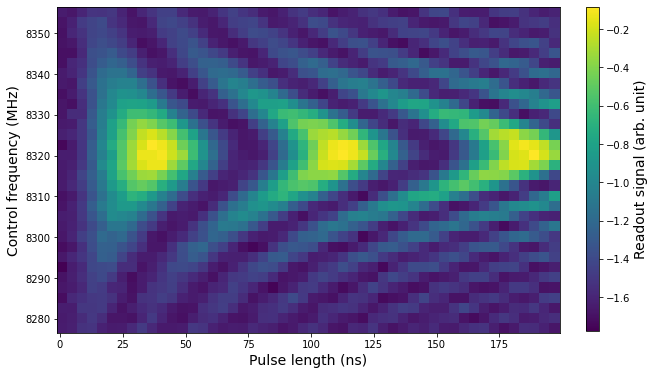

In [496]:
# データ生成
X = {}
Y = {}
Z = {}

X, Y = np.meshgrid(pulse_length_list, FREQUENCY_LIST + CTRL_TARGET_FREQUENCY)
Z = np.zeros((len(FREQUENCY_LIST), len(pulse_length_list)))
for i in range(len(FREQUENCY_LIST)):
    Z[i] = chevron_after[FREQUENCY_LIST[i]].imag

        
# Figureの初期化
fig = plt.figure(figsize=(9, 6)) #figureインスタンスを生成

# Figure内にAxesを追加()
#subplotを4つ並べる
fig, ax = plt.subplots(1, 1, figsize=(9,6))
hoge00 = ax.pcolor(X, Y, Z)

cax = plt.axes([0.94, 0.13, 0.02, 0.75]) #[左端からの距離, 下端からの距離, 太さ, 長さ]
cbar = plt.colorbar(hoge00, cax=cax)
cbar.set_label("Readout signal (arb. unit)", fontsize = 14) #カラーバーのラベル

ax.set_xlabel('Pulse length (ns)', fontsize = 14)
ax.set_ylabel('Control frequency (MHz)', fontsize = 14)
# ax.set_title(folder)

plt.show()